# Leaf Plots for interpreting test results

_Author: Peter Chng_

Test performance is usually measured in terms of the _sensitivity_ and _specificity_, which are the True Positive Rate (TPR) and True Negative Rate (TNR) respectively. They are defined as:

- **Sensitivity**: The proportion of positives correctly identified as positive. For example, if there were 100 positives but the test only identified 90 of them as positive, the sensitivity would be 0.90.
- **Specificity**: The proportion of negatives correctly identified as negative. For example, if there were 50 negatives but the test only identified 40 of them as negative, the specificity would be 0.80.

It's not straightforward to understand how sensitivity and specificity translate into answering the question: _What proportion of people who test positive will **actually** have the condition?_ This is known as the Positive Predictive Value (PPV) or the Precision of the test, and it depends not only on the sensitivity and specificity but also the _base rate_ of the condition in the population being tested.

This base rate can also be thought of as the _pre-test_ probability.

# Enter Leaf Plots
In "[_The leaf plot: a novel way of presenting the value of tests_](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6428474/)" (MG Coulthard, 2019), _leaf plots_ are proposed as a way of making the interpretation of a test result (positive or negative) easier in determining whether the patient _actually_ has the condition or not.

We can think of this in an informal Bayesian context. The pre-test probability of the condition is our _prior_, and the test result (positive or negative) is our _data_ that when combined with the knowledge of the test's sensitivity and specificity, transforms the pre-test probability into a post-test probability or _posterior_.

Let's take a look at these leaf plots and discuss their usage.

In [1]:
# Imports
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
# Versions used
import matplotlib # Only imported to get the version info
print(f'matplotlib version: {matplotlib.__version__}')
print(f'numpy version: {np.__version__}')

matplotlib version: 3.2.2
numpy version: 1.19.5


In [3]:
# Helper functions

# Positive Predictive Value(PPV) or Precision as a function of the base rate, sensitivity, specificity
# PPV is the probability of being positive given a positive test.
# Is the fraction of all positive tests that were actually positive.
def calculate_ppv(base_rate, sensitivity, specificity):
  # PPV = TP/(TP + FP)
  true_positive = sensitivity*base_rate          # Proportion of those actually positive identified as positive.
  false_positive = (1-specificity)*(1-base_rate) # Proportion of those actually negative identified as positive.
  return true_positive/(true_positive + false_positive)

# False Omission Rate (FOR) or (1 - Negative Predictive Value/NPV) as a function of the base rate, sensitivity, specificity
# FOR is the probability of being positive given a negative test.
# Is the fraction of all negative tests that were actually positive.
# (By contrast, NPV is the fraction of all negative tests that were actually negative, and this is the complement of the FOR)
def calculate_for(base_rate, sensitivity, specificity):
  # FOR = FN/(FN + TN)
  false_negative = (1-sensitivity)*base_rate  # Proportion of those actually positive identified as negative.
  true_negative = specificity*(1 - base_rate) # Proportion of those actually negative identified as negative.
  return false_negative/(false_negative + true_negative)

# helper function for generating the leaf plot
def leaf_plot(sensitivity, specificity):
  axes_font_size = 16
  x = np.linspace(0, 1, 100)
  plt.figure(figsize=(10, 10))
  plt.xlim(0, 1) 
  plt.ylim(0, 1)
  plt.ylabel('Post-test probability of being positive', fontsize=axes_font_size)
  plt.xlabel('Pre-test probability of being positive (base rate)', fontsize=axes_font_size)
  plt.title(f'Leaf Plot for a {sensitivity * 100}% sensitive, {specificity * 100}% specific test', fontsize=18)
  plt.xticks(ticks=[p/20 for p in range(0, 21)])
  plt.yticks(ticks=[p/20 for p in range(0, 21)])
  ax = plt.gca()
  ax.xaxis.set_tick_params(labelsize='medium')
  ax.yaxis.set_tick_params(labelsize='large')
  plt.grid()
  plt.plot(x, calculate_ppv(x, sensitivity=sensitivity, specificity=specificity), label="PPV", color='red')
  plt.plot(x, calculate_for(x, sensitivity=sensitivity, specificity=specificity), label="FOR", color='green')
  plt.legend(loc=(1.04,0), fontsize=16)

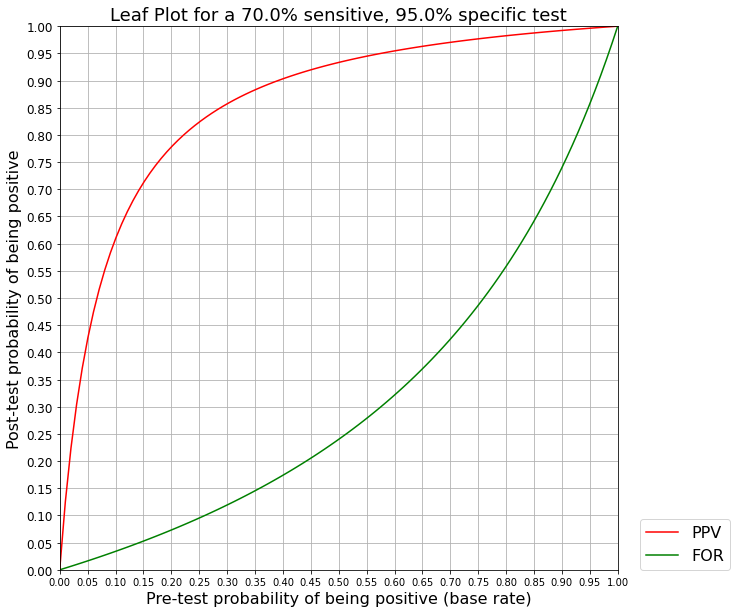

In [4]:
# Make a leaf plot
# A reproduction of the plot on page 6 of this paper: sensitivity of 70% and specificity of 95%
# https://www.bmj.com/content/bmj/369/bmj.m1808.full.pdf
leaf_plot(sensitivity=0.70, specificity=0.95)

# Interpreting a Leaf Plot
A leaf plot consists of two plots:

1. The PPV as a function of the pre-test probability. (base rate)
2. The FOR as a function of the pre-test probability.

The PPV is always above or equal to the FOR.

We can use a leaf plot to determine the _post-test probability_ of being positive given a test result and the pre-test probability in the following way:

- If the test result is _positive_, then the post-test probability of being positive is the corresponding point on the **PPV** curve.
  - For example in the above leaf plot, if we have a pre-test probability of 0.10, then a positive test yields a post-test probability of ~0.60. In other words, there is only a 60% chance that a positive result really means you are positive.
- If the test result is _negative_, then the post-test probability of being positive is the corresponding point on the **FOR** curve.
  - For example in the above leave plot, if we have a base rate of 0.10, then the post negative test yields a post-test probability of ~0.04.

This can be easier to see if we draw horizontal and vertical lines on the chart. If we draw a vertical line at the value of the pre-test probability, it will intersect both the PPV and the FOR curves. We can then draw a horizontal line from this intersection point over to the left-hand side of the graph, and read off the associated post-test probability.

The following graph illustrates this:

Post-test probability for a positive test with a base rate of 0.5 is 0.933
Post-test probability for a negative test with a base rate of 0.1 is 0.034


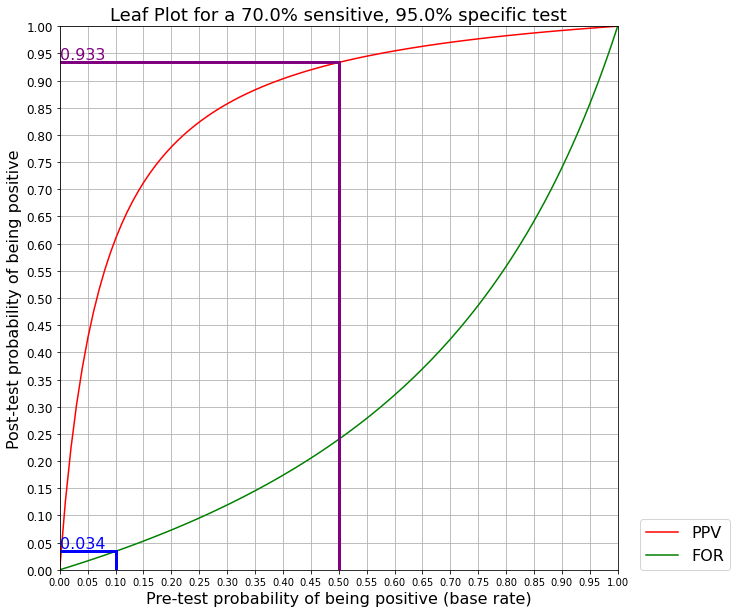

In [5]:
# Generate the plot
sensitivity = 0.70
specificity = 0.95
leaf_plot(sensitivity, specificity)

def draw_intersection_lines(base_rate, sensitivity, specificity, post_test_function, plot_color):
  # post_test_function is either the PPV or the FOR function.
  post_test_probability = post_test_function(base_rate, sensitivity, specificity)

  # NOTE Have to use this roundabout way of drawing lines because a more straightforward way is not available until matplotlib 3.3.
  # Reference: https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib
  x1, y1 = [base_rate, base_rate], [0, post_test_probability]
  x2, y2 = [base_rate, 0], [post_test_probability, post_test_probability]
  plt.plot(x1, y1, x2, y2, color=plot_color, linewidth=3)
  ax = plt.gca()
  ax.text(0, post_test_probability, f'{post_test_probability:.3f}',
          verticalalignment='bottom', horizontalalignment='left',
          transform=ax.transAxes,
          color=plot_color, fontsize=16)

# Lines intersecting the PPV for a base rate of 0.50.
base_rate_2 = 0.50
print(f'Post-test probability for a positive test with a base rate of {base_rate_2} is {calculate_ppv(base_rate_2, sensitivity, specificity):.3f}')
draw_intersection_lines(base_rate_2, sensitivity, specificity, calculate_ppv, 'purple')

# Lines intersecting the FOR for a base rate of 0.10.
base_rate_1 = 0.10
draw_intersection_lines(base_rate_1, sensitivity, specificity, calculate_for, 'blue')
print(f'Post-test probability for a negative test with a base rate of {base_rate_1} is {calculate_for(base_rate_1, sensitivity, specificity):.3f}')

In the above graph, the BLUE line represents a _negative_ test result when the pre-test probability (base rate) is 10%. In that case, we go UP from 0.10 on the x-axis until we hit the FOR curve, and then over to the LEFT to read off the post-test probability, which is ~3.4% in this case.

The PURPLE line represents a _positive_ test result when the pre-test probabilty is 50%. We go UP from 0.50 on the x-axis until we hit the PPV curve, and then over to the LEFT to read off the post-test probability, which is ~93.3%.

# Implications
A leaf plot helps to visualize the the post test-probability as a function of the sensitivity and specificity of a test, and the pre-test probability.

For example, for our 70% sensitive and 95% specific test, if the pre-test probability if only 5% (0.05), then only 42% if people who test positive will actually be positive! **This means many positive tests under these conditions will be false positives, and thus a positive test here is not a reliable indicator**. (By contrast, only 1.6% of people who test negative will actually be positive, meaning a negative test here is a reliable indicator.)

In [6]:
sensitivity = 0.70
specificity = 0.95
base_rate_3 = 0.05
print(f'Post-test probability for a positive test with a base rate of {base_rate_3} is {calculate_ppv(base_rate_3, sensitivity, specificity):.3f}')
print(f'Post-test probability for a negative test with a base rate of {base_rate_3} is {calculate_for(base_rate_3, sensitivity, specificity):.3f}')

Post-test probability for a positive test with a base rate of 0.05 is 0.424
Post-test probability for a negative test with a base rate of 0.05 is 0.016


However, if the pre-test probability is considerable higher at 50%, then we have the reverse problem: **Many people who test negative will actually be positive**. Under these conditions, 24% of people who test negative will actually be positive, so a negative test cannot be reliably used to exclude people from having the condition! This is important if the condition is a disease that is contagious. (By contrast, 93.3% of people who test positive here will be actually positive, so a positive test here is a reliable indicator)

In [7]:
sensitivity = 0.70
specificity = 0.95
base_rate_4 = 0.50
print(f'Post-test probability for a positive test with a base rate of {base_rate_4} is {calculate_ppv(base_rate_4, sensitivity, specificity):.3f}')
print(f'Post-test probability for a negative test with a base rate of {base_rate_4} is {calculate_for(base_rate_4, sensitivity, specificity):.3f}')

Post-test probability for a positive test with a base rate of 0.5 is 0.933
Post-test probability for a negative test with a base rate of 0.5 is 0.240


Taken all together, the leaf plot helps us visualize how important the pre-test probability is in determining the fraction of false positives or false negatives a test will generate.

# References:
1. The leaf plot: a novel way of presenting the value of tests: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6428474/
2. Interpreting a covid-19 test result: https://www.bmj.com/content/bmj/369/bmj.m1808.full.pdf
3. Interpreting a covid-19 test result (Interactive Visualization): https://www.bmj.com/content/369/bmj.m1808
4. https://en.wikipedia.org/wiki/Sensitivity_and_specificity
5. https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values